In [1]:
import pandas as pd
import numpy as np

In [2]:
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=cols)

In [3]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


## 数据清洗

In [4]:
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[continuous_values_cols]

In [5]:
numeric_cars = numeric_cars.replace('?',np.nan)
numeric_cars = numeric_cars.astype(float)

In [6]:
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [7]:
numeric_cars = numeric_cars.dropna()

In [8]:
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

### 标准化数据

In [9]:
price_col = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.min())/numeric_cars.std()
numeric_cars['price'] = price_col

## 一元线性回归

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


def knn_train_test(train_col, target_col, df):
    knn = KNeighborsRegressor()
    np.random.seed(1)
    #随机顺序
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    last_train_row = int(len(rand_df) / 2)
    
    #将前半部分当作练习数据，后半部分为测试数据
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    #线性回归
    knn.fit(train_df[[train_col]],train_df[target_col])
    predict = knn.predict(test_df[[train_col]])
    mse = mean_squared_error(test_df[target_col], predict)
    rmse = np.sqrt(mse)
    return rmse

rmse_col = {}
for col in numeric_cars.columns:
    if col == 'price':
        continue
    rmse = knn_train_test(col,'price',numeric_cars)
    rmse_col[col] = rmse
rmse_results_series = pd.Series(rmse_col)
rmse_results_series.sort_values()

curb-weight          2390.860581
width                2399.439853
city-mpg             2722.061443
horsepower           2918.443706
length               3630.089319
highway-mpg          3762.044795
wheel-base           3934.588779
bore                 4060.936349
stroke               4978.056555
normalized-losses    5218.093022
height               5226.393339
peak-rpm             5998.628981
compression-rate     6301.123333
dtype: float64

由此可以看出来，curb-weight 和 width这两个因素在k值默认的情况下表现的最好

### 修改默认的K值

In [11]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


def knn_train_test(train_col, target_col, df):
    np.random.seed(1)
    #随机顺序
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    last_train_row = int(len(rand_df) / 2)
    
    #将前半部分当作练习数据，后半部分为测试数据
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    #线性回归
    k_value = [1,3,5,7,9]
    k_rmse = {}
    for i in k_value:
        knn = KNeighborsRegressor(n_neighbors=i)
        knn.fit(train_df[[train_col]],train_df[target_col])
        predict = knn.predict(test_df[[train_col]])
        mse = mean_squared_error(test_df[target_col], predict)
        rmse = np.sqrt(mse)
        k_rmse[i] = rmse
    return k_rmse

rmse_col = {}
for col in numeric_cars.columns:
    if col == 'price':
        continue
    rmse = knn_train_test(col,'price',numeric_cars)
    rmse_col[col] = rmse
rmse_col

{'normalized-losses': {1: 4499.9591637036,
  3: 4505.065183120736,
  5: 5218.093022168156,
  7: 5567.858758636254,
  9: 5375.67607337285},
 'wheel-base': {1: 4239.563761461785,
  3: 4285.42843216664,
  5: 3934.588778830642,
  7: 4026.258534860972,
  9: 4052.5122965556275},
 'length': {1: 3722.7733630319212,
  3: 3831.485265750955,
  5: 3630.089318804704,
  7: 3648.6663296962606,
  9: 3524.435917961173},
 'width': {1: 2967.403311398705,
  3: 2260.849337392673,
  5: 2399.4398531740694,
  7: 2389.6194579527782,
  9: 2558.992458311968},
 'height': {1: 6279.226392438801,
  3: 5188.521852769502,
  5: 5226.393339340238,
  7: 5391.5573114455565,
  9: 5527.497385239288},
 'curb-weight': {1: 2945.27863919528,
  3: 2557.8881366166984,
  5: 2390.8605812552096,
  7: 2405.4334088025953,
  9: 2390.3598570063996},
 'bore': {1: 5219.654946689484,
  3: 4290.706593421803,
  5: 4060.936348553126,
  7: 3985.666566470611,
  9: 4082.1423382713406},
 'stroke': {1: 7063.64661223224,
  3: 4819.164974782111,
  5

### 单变量与k值可视化

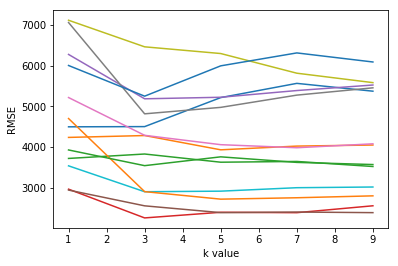

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

for _,v in rmse_col.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

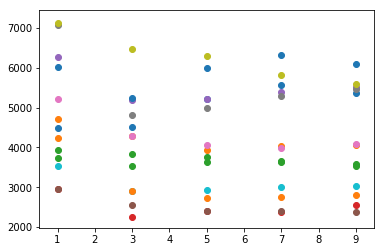

In [13]:
for _,v in rmse_col.items():
    x = list(v.keys())
    y = list(v.values())
    plt.scatter(x,y)


## 多变量模型

In [14]:
feature_avg_rmse = {}
for X,k in rmse_col.items():
    avg_rmse = np.mean(list(k.values()))
    feature_avg_rmse[X] = avg_rmse
series_avg_rmse = pd.Series(feature_avg_rmse)
series_avg_rmse = series_avg_rmse.sort_values()
series_avg_rmse

width                2515.260884
curb-weight          2537.964125
horsepower           3077.578794
city-mpg             3178.474592
length               3671.490039
highway-mpg          3687.317481
wheel-base           4107.670361
bore                 4327.821359
normalized-losses    5033.330440
stroke               5519.594200
height               5522.639256
peak-rpm             5933.776262
compression-rate     6258.052980
dtype: float64

In [15]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    #随机顺序
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    last_train_row = int(len(rand_df) / 2)
    
    #将前半部分当作练习数据，后半部分为测试数据
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    #线性回归
    k_value = [5]
    k_rmse = {}
    for i in k_value:
        knn = KNeighborsRegressor(n_neighbors=i)
        knn.fit(train_df[train_cols], train_df[target_col])
        predict = knn.predict(test_df[train_cols])
        mse = mean_squared_error(test_df[target_col], predict)
        rmse = np.sqrt(mse)
        k_rmse[i] = rmse
    return k_rmse
k_rmse_results = {}

two_best_features = ['horsepower', 'width']
rmse_val = knn_train_test(two_best_features, 'price', numeric_cars)
k_rmse_results["two best features"] = rmse_val

three_best_features = ['horsepower', 'width', 'curb-weight']
rmse_val = knn_train_test(three_best_features, 'price', numeric_cars)
k_rmse_results["three best features"] = rmse_val

four_best_features = ['horsepower', 'width', 'curb-weight', 'city-mpg']
rmse_val = knn_train_test(four_best_features, 'price', numeric_cars)
k_rmse_results["four best features"] = rmse_val

five_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg']
rmse_val = knn_train_test(five_best_features, 'price', numeric_cars)
k_rmse_results["five best features"] = rmse_val

six_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg', 'length']
rmse_val = knn_train_test(six_best_features, 'price', numeric_cars)
k_rmse_results["six best features"] = rmse_val

k_rmse_results

{'two best features': {5: 2053.118572440472},
 'three best features': {5: 1833.5905044474896},
 'four best features': {5: 1705.77226146986},
 'five best features': {5: 1809.3550520834765},
 'six best features': {5: 1916.991993332262}}

## 多元模型最优解

In [16]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    #随机顺序
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    last_train_row = int(len(rand_df) / 2)
    
    #将前半部分当作练习数据，后半部分为测试数据
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    #线性回归
    k_value = [x for x in range(1,26)]
    k_rmse = {}
    for i in k_value:
        knn = KNeighborsRegressor(n_neighbors=i)
        knn.fit(train_df[train_cols], train_df[target_col])
        predict = knn.predict(test_df[train_cols])
        mse = mean_squared_error(test_df[target_col], predict)
        rmse = np.sqrt(mse)
        k_rmse[i] = rmse
    return k_rmse
k_rmse_results = {}

two_best_features = ['horsepower', 'width']
rmse_val = knn_train_test(two_best_features, 'price', numeric_cars)
k_rmse_results["two best features"] = rmse_val

three_best_features = ['horsepower', 'width', 'curb-weight']
rmse_val = knn_train_test(three_best_features, 'price', numeric_cars)
k_rmse_results["three best features"] = rmse_val

four_best_features = ['horsepower', 'width', 'curb-weight', 'city-mpg']
rmse_val = knn_train_test(four_best_features, 'price', numeric_cars)
k_rmse_results["four best features"] = rmse_val

five_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg']
rmse_val = knn_train_test(five_best_features, 'price', numeric_cars)
k_rmse_results["five best features"] = rmse_val

six_best_features = ['horsepower', 'width', 'curb-weight' , 'city-mpg' , 'highway-mpg', 'length']
rmse_val = knn_train_test(six_best_features, 'price', numeric_cars)
k_rmse_results["six best features"] = rmse_val

k_rmse_results

{'two best features': {1: 2465.1697887772357,
  2: 2072.4008186460937,
  3: 2045.4817688424082,
  4: 2020.6616105947205,
  5: 2053.118572440472,
  6: 2048.1327058818183,
  7: 2020.6081110696375,
  8: 2100.4535145062273,
  9: 2267.9248147321327,
  10: 2241.651448569781,
  11: 2302.2650002338246,
  12: 2307.4932564116884,
  13: 2326.4670943725437,
  14: 2336.411000283319,
  15: 2384.712372069219,
  16: 2401.3864850714044,
  17: 2471.645099149657,
  18: 2492.045624989503,
  19: 2543.590394926169,
  20: 2582.0990341132833,
  21: 2625.7611069531786,
  22: 2642.8318520124135,
  23: 2649.112184339763,
  24: 2668.429046725593,
  25: 2741.758427998353},
 'three best features': {1: 1918.6438863165827,
  2: 1734.8789529099718,
  3: 1845.3396186971474,
  4: 1820.846987839725,
  5: 1833.5905044474896,
  6: 1965.3875681543211,
  7: 2051.2038563875567,
  8: 2146.5999822939475,
  9: 2142.8897581505257,
  10: 2144.5292534435152,
  11: 2178.7674441343743,
  12: 2242.6830455107847,
  13: 2330.15380215898

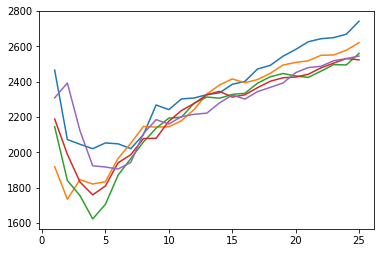

In [27]:
for _,k in k_rmse_results.items():
    x = list(k.keys())
    y = list(k.values())
    plt.plot(x,y)